In [1]:
%cd ..
%env DWAVE_API_TOKEN=DEV-a6b0d896430ef70f76c9622770293f0227d28aa4
!source source.me

import os
import sys
import numpy as np

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)

from models.rbm.pegasusRBM import PegasusRBM
from models.samplers.pgbs import PGBS
import torch
import matplotlib.pyplot as plt
from models.rbm.qimeraRBM import QimeraRBM
from models.samplers.pcd import PCD
import itertools


def energy_exp(p0_state, p1_state, p2_state, p3_state, _weight_dict, _bias_dict):
        """Energy expectation value under the 4-partite BM
        Overrides energy_exp in gumbolt.py

        :param p0_state (torch.Tensor) : (batch_size, n_nodes_p1)
        :param p1_state (torch.Tensor) : (batch_size, n_nodes_p2)
        :param p2_state (torch.Tensor) : (batch_size, n_nodes_p3)
        :param p3_state (torch.Tensor) : (batch_size, n_nodes_p4)

        :return energy expectation value over the current batch
        """
        w_dict = _weight_dict
        b_dict = _bias_dict

        w_dict_cp = {}

        # Broadcast weight matrices (n_nodes_pa, n_nodes_pb) to
        # (batch_size, n_nodes_pa, n_nodes_pb)
        for key in w_dict.keys():
            w_dict_cp[key] = w_dict[key] + torch.zeros((p0_state.size(0),) +
                                                    w_dict[key].size(),
                                                    device=w_dict[key].device)

        # Prepare px_state_t for torch.bmm()
        # Change px_state.size() to (batch_size, 1, n_nodes_px)
        p0_state_t = p0_state.unsqueeze(2).permute(0, 2, 1)
        p1_state_t = p1_state.unsqueeze(2).permute(0, 2, 1)
        p2_state_t = p2_state.unsqueeze(2).permute(0, 2, 1)

        # Prepare py_state for torch.bmm()
        # Change py_state.size() to (batch_size, n_nodes_py, 1)
        p1_state_i = p1_state.unsqueeze(2)
        p2_state_i = p2_state.unsqueeze(2)
        p3_state_i = p3_state.unsqueeze(2)

        # Compute the energies for batch samples
        batch_energy = -torch.matmul(p0_state, b_dict['0']) - \
            torch.matmul(p1_state, b_dict['1']) - \
            torch.matmul(p2_state, b_dict['2']) - \
            torch.matmul(p3_state, b_dict['3']) - \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['01'], p1_state_i)).reshape(-1) - \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['02'], p2_state_i)).reshape(-1) - \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['03'], p3_state_i)).reshape(-1) - \
            torch.bmm(p1_state_t,
                      torch.bmm(w_dict_cp['12'], p2_state_i)).reshape(-1) - \
            torch.bmm(p1_state_t,
                      torch.bmm(w_dict_cp['13'], p3_state_i)).reshape(-1) - \
            torch.bmm(p2_state_t,
                      torch.bmm(w_dict_cp['23'], p3_state_i)).reshape(-1)

        return batch_energy

def sample_energies_rbm(rbm, rbm_vis, rbm_hid):
    """
    Compute the energies of samples produced by the RBM

    Returns:
        rbm_energy_exp : -vis^T W hid - a^T hid - b^T vis
    """
    # Broadcast W to (pcd_batchSize * nVis * nHid)
    w, vbias, hbias = rbm.weights, rbm.visible_bias, rbm.hidden_bias
    w = w + torch.zeros((rbm_vis.size(0),) + w.size(), device=rbm_vis.device)
    vbias = vbias.to(rbm_vis.device)
    hbias = hbias.to(rbm_hid.device)

    # Prepare H, V for torch.matmul()
    # Change V.size() from (batchSize * nVis) to (batchSize * 1 * nVis)
    vis = rbm_vis.unsqueeze(2).permute(0, 2, 1)
    # Change H.size() from (batchSize * nHid) to (batchSize * nHid * 1)
    hid = rbm_hid.unsqueeze(2)

    batch_energies = (- torch.matmul(vis, torch.matmul(w, hid)).reshape(-1) 
                      - torch.matmul(rbm_vis, vbias)
                      - torch.matmul(rbm_hid, hbias))

    return batch_energies

def plot_sample_energies(energies,bins=100):
    """
    Plot the energies of the samples produced by the histograms        
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    
    ax.hist(energies, bins=100, density=True)
    
    ax.set_xlabel("Energy", fontsize=60)
    ax.set_ylabel("Frequency", fontsize=60)
    
    ax.tick_params(axis='both', which='major', labelsize=60)
    
    plt.show()
    plt.close()

def generate_samples_rbm(batch_size, _NUM_NODES,n_gibbs_sampling_steps):
    crbm = QimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
    crbm_sampler = PCD(batch_size, crbm, n_gibbs_sampling_steps = n_gibbs_sampling_steps)
    crbm_vis, crbm_hid = crbm_sampler.block_gibbs_sampling()
    crbm_sample_energies = sample_energies_rbm(crbm, crbm_vis, crbm_hid)
    plot_sample_energies(crbm_sample_energies.detach().cpu().numpy())
    return crbm_sample_energies, crbm, crbm_vis, crbm_hid


def prbm_sample_and_plot(prbm, number_of_samples, gibbs_steps):
    
    prbm_sampler = PGBS(prbm, number_of_samples, gibbs_steps)
    p0_state, p1_state, p2_state, p3_state = prbm_sampler.block_gibbs_sampling()
    energy = energy_exp(p0_state, p1_state, p2_state, p3_state, prbm._weight_dict, prbm._bias_dict)
    # plot_sample_energies(energy.detach().cpu().numpy())
    return energy, prbm, p0_state, p1_state, p2_state, p3_state

/home/blazerjia/CaloQVAE
env: DWAVE_API_TOKEN=DEV-a6b0d896430ef70f76c9622770293f0227d28aa4


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[15:44:11.198] INFO   CaloQVAE                                          Willkommen!
[15:44:11.199] INFO   CaloQVAE                                          Loading configuration.


In [2]:
prbm_3 = PegasusRBM(3)
prbm_4 = PegasusRBM(4)
prbm_5 = PegasusRBM(5)
prbm_6 = PegasusRBM(6)

2023-09-01 15:44:11,297 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[15:44:11.297] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-09-01 15:44:11,394 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[15:44:11.394] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-09-01 15:44:15,276 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[15:44:15.276] INFO   dwave.cloud.client.base                

40279 34


2023-09-01 15:44:19,201 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[15:44:19.201] INFO   dwave.cloud.client.base                           Received solver data for 6 solver(s).
2023-09-01 15:44:19,307 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[15:44:19.307] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')
2023-09-01 15:44:19,337 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage2_prototype1.1')
[15:44:19.337] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage2_prototype1.1')
2023-09-01 15:44:19,481 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system6.2')
[15:44:19.481] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system6.2')
2023-09-01 15:44:19,700 dw

40279 56


2023-09-01 15:44:23,265 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[15:44:23.265] INFO   dwave.cloud.client.base                           Received solver data for 6 solver(s).
2023-09-01 15:44:23,369 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[15:44:23.369] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')
2023-09-01 15:44:23,419 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage2_prototype1.1')
[15:44:23.419] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage2_prototype1.1')
2023-09-01 15:44:23,571 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system6.2')
[15:44:23.571] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system6.2')
2023-09-01 15:44:23,791 dw

40279 70


2023-09-01 15:44:27,663 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[15:44:27.663] INFO   dwave.cloud.client.base                           Received solver data for 6 solver(s).
2023-09-01 15:44:27,777 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[15:44:27.777] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')
2023-09-01 15:44:27,809 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage2_prototype1.1')
[15:44:27.809] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage2_prototype1.1')
2023-09-01 15:44:27,924 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system6.2')
[15:44:27.924] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system6.2')


40279 92


In [3]:
def compute_partition_function(prbm, num_of_node_per_partition, number_of_steps=1000, number_of_samples= 10000):
    prbm_samples = prbm_sample_and_plot(prbm, number_of_samples, number_of_steps)
    sampling_energy = prbm_samples[0]
    # mc_partition_distribution = torch.exp(-(sampling_energy))/torch.sum(torch.exp(-sampling_energy))

    lst = list(itertools.product([0, 1], repeat=num_of_node_per_partition*4))
    lst_0 = [node[:num_of_node_per_partition] for node in lst]
    lst_1 = [node[num_of_node_per_partition:2*num_of_node_per_partition] for node in lst]
    lst_2 = [node[2*num_of_node_per_partition:3*num_of_node_per_partition] for node in lst]
    lst_3 = [node[3*num_of_node_per_partition:] for node in lst]
    p0_state_list = torch.tensor(lst_0).float()
    p1_state_list = torch.tensor(lst_1).float()
    p2_state_list = torch.tensor(lst_2).float()
    p3_state_list = torch.tensor(lst_3).float()
    true_state_energy = energy_exp(p0_state_list, p1_state_list, p2_state_list, p3_state_list, prbm_samples[1]._weight_dict, prbm_samples[1]._bias_dict)

    return sampling_energy.detach().numpy(), true_state_energy.detach().numpy()

In [4]:
def plot_energy_distribution(mc_partition,energy_true, min_bin, max_bin, bins = 100, node_per_partition = 3, number_of_steps = 3000, yscale = 'log'):
    """
    Plot the energies of the samples produced by the histograms        
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    bin_width = (max_bin-min_bin)/bins
    counts, bin_edges = np.histogram(energy_true, bins = np.arange(min_bin, max_bin+bin_width, bin_width))
    num_of_samples = len(mc_partition)
    recaled_function = np.exp(-bin_edges)/np.sum(np.exp(-bin_edges))
    recaled_energy = counts*recaled_function[:-1]
    ax.step(bin_edges[:-1], recaled_energy/(np.sum(recaled_energy)*bin_width), linestyle='-', color='b', alpha=0.5, where = 'post',label='Real')
    # ax.fill_between(bin_edges[:-1], recaled_energy, color='b', alpha=0.5,label='Real')
    ax.hist(mc_partition, label='MC', alpha = 0.5, bins = np.arange(min_bin, max_bin+bin_width, bin_width),density=True)
    
    ax.set_xlabel(f'Energy Distribution: N = {num_of_samples}, Steps = {number_of_steps}, nodes = {node_per_partition}^4', fontsize=50)
    ax.set_ylabel("Density", fontsize=60)
    ax.legend(fontsize=40)
    ax.tick_params(axis='x', which='major', labelsize=40)
    ax.tick_params(axis='y', which='major', labelsize=40)
    ax.set_yscale(yscale)
    
    plt.show()
    plt.close()

In [5]:
sampling_energy_3_10240, true_state_energy_3_10240 = compute_partition_function(prbm_6, 6, number_of_steps = 500, number_of_samples= 10240)

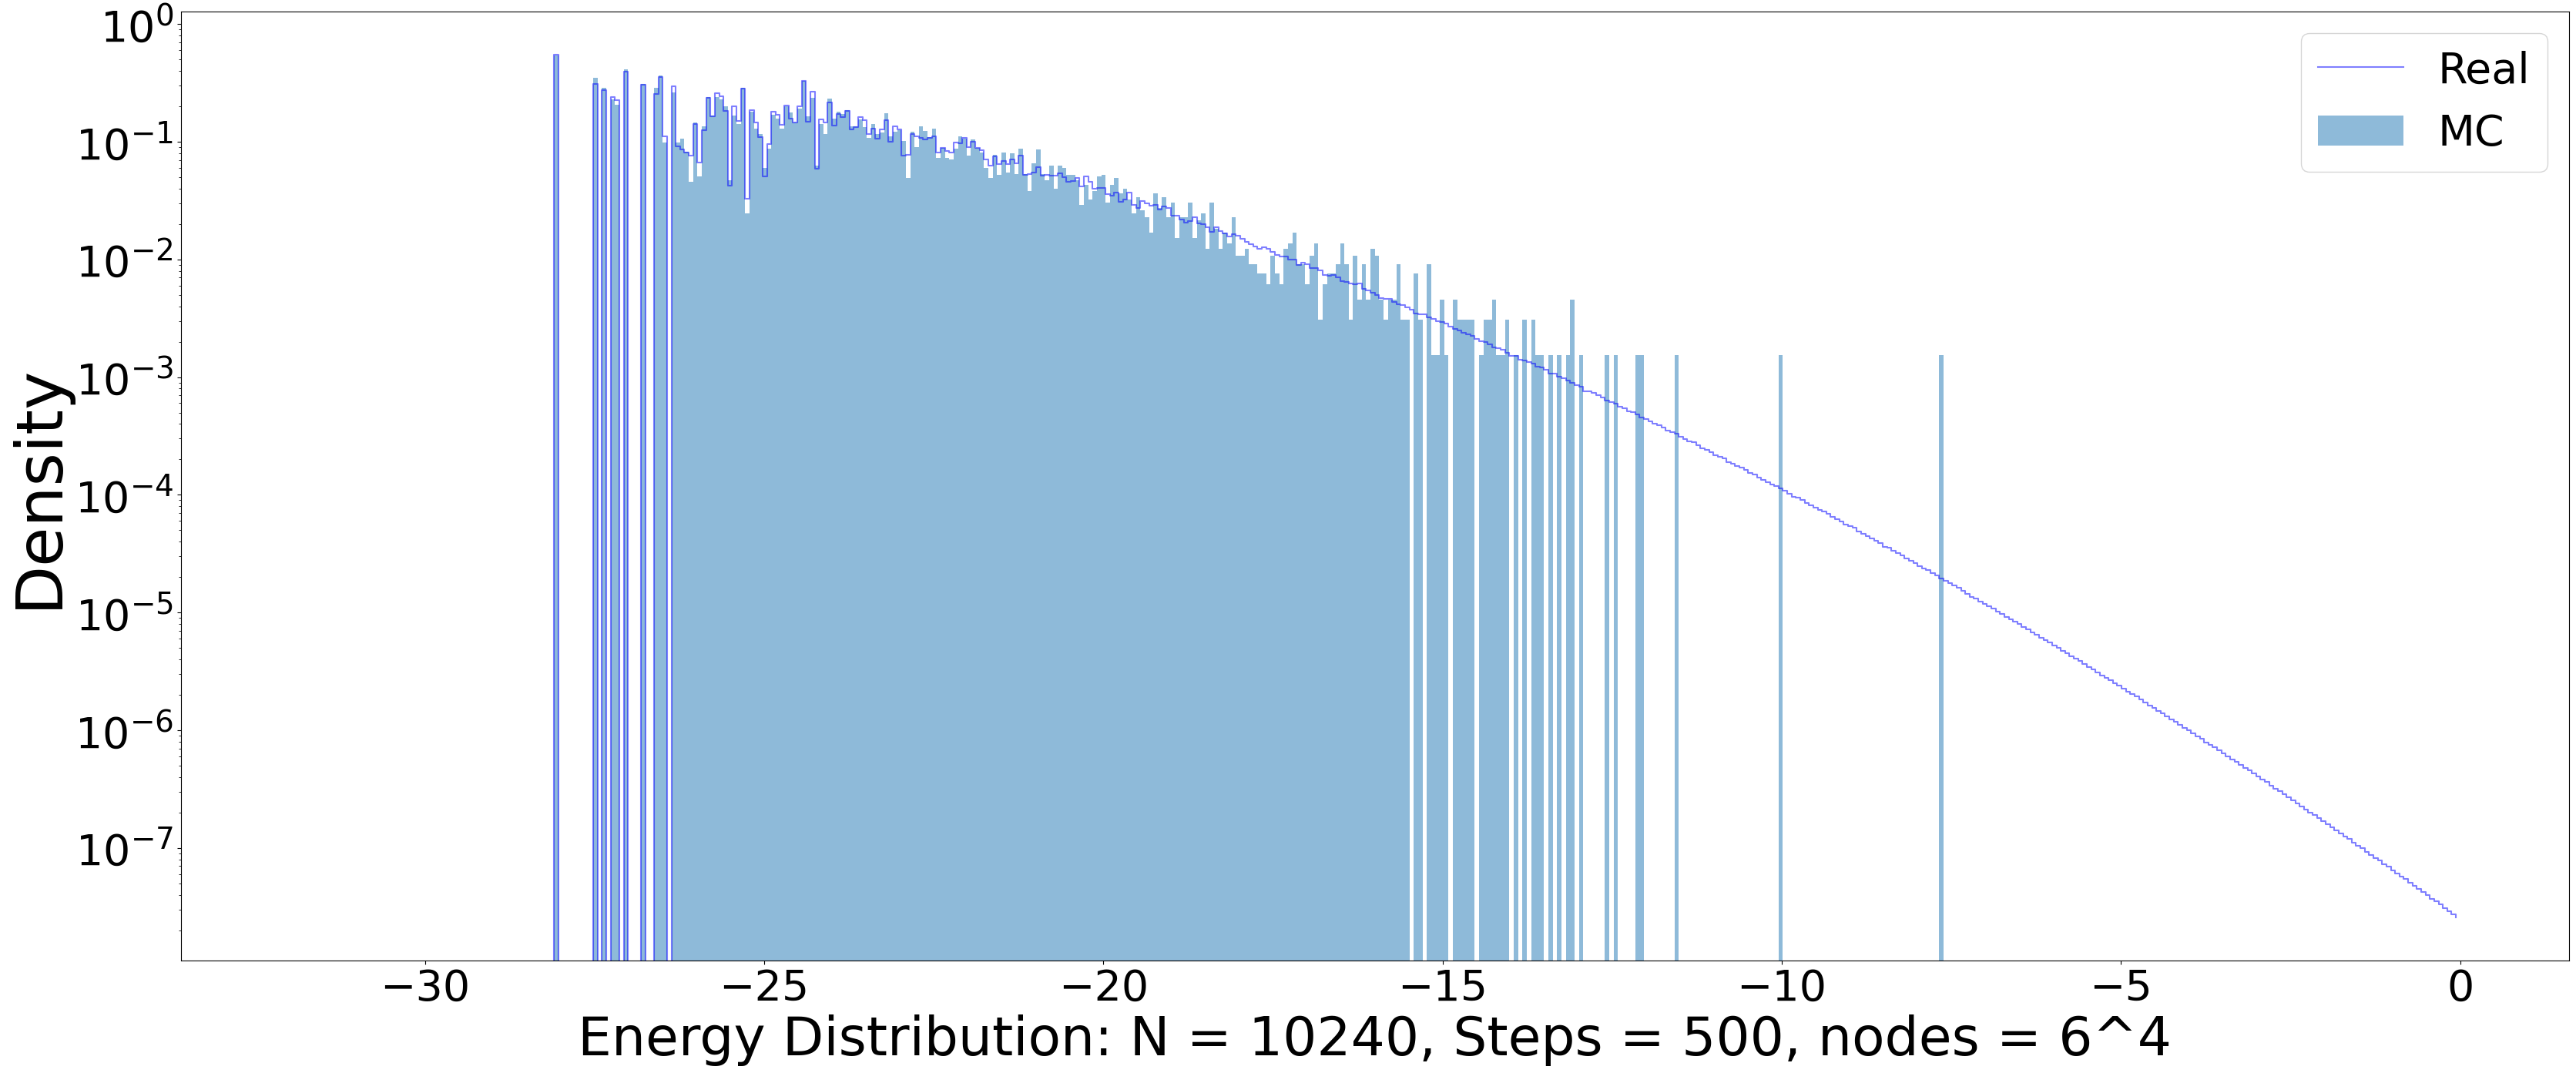

In [35]:
plot_energy_distribution(sampling_energy_3_10240, true_state_energy_3_10240, -32, 0, bins = 500, number_of_steps= 500, node_per_partition=6)

In [13]:
sampling_energy_6_10240_3000, true_state_energy_6_10240_3000 = compute_partition_function(prbm_6, 6, number_of_steps = 3000, number_of_samples= 10240)

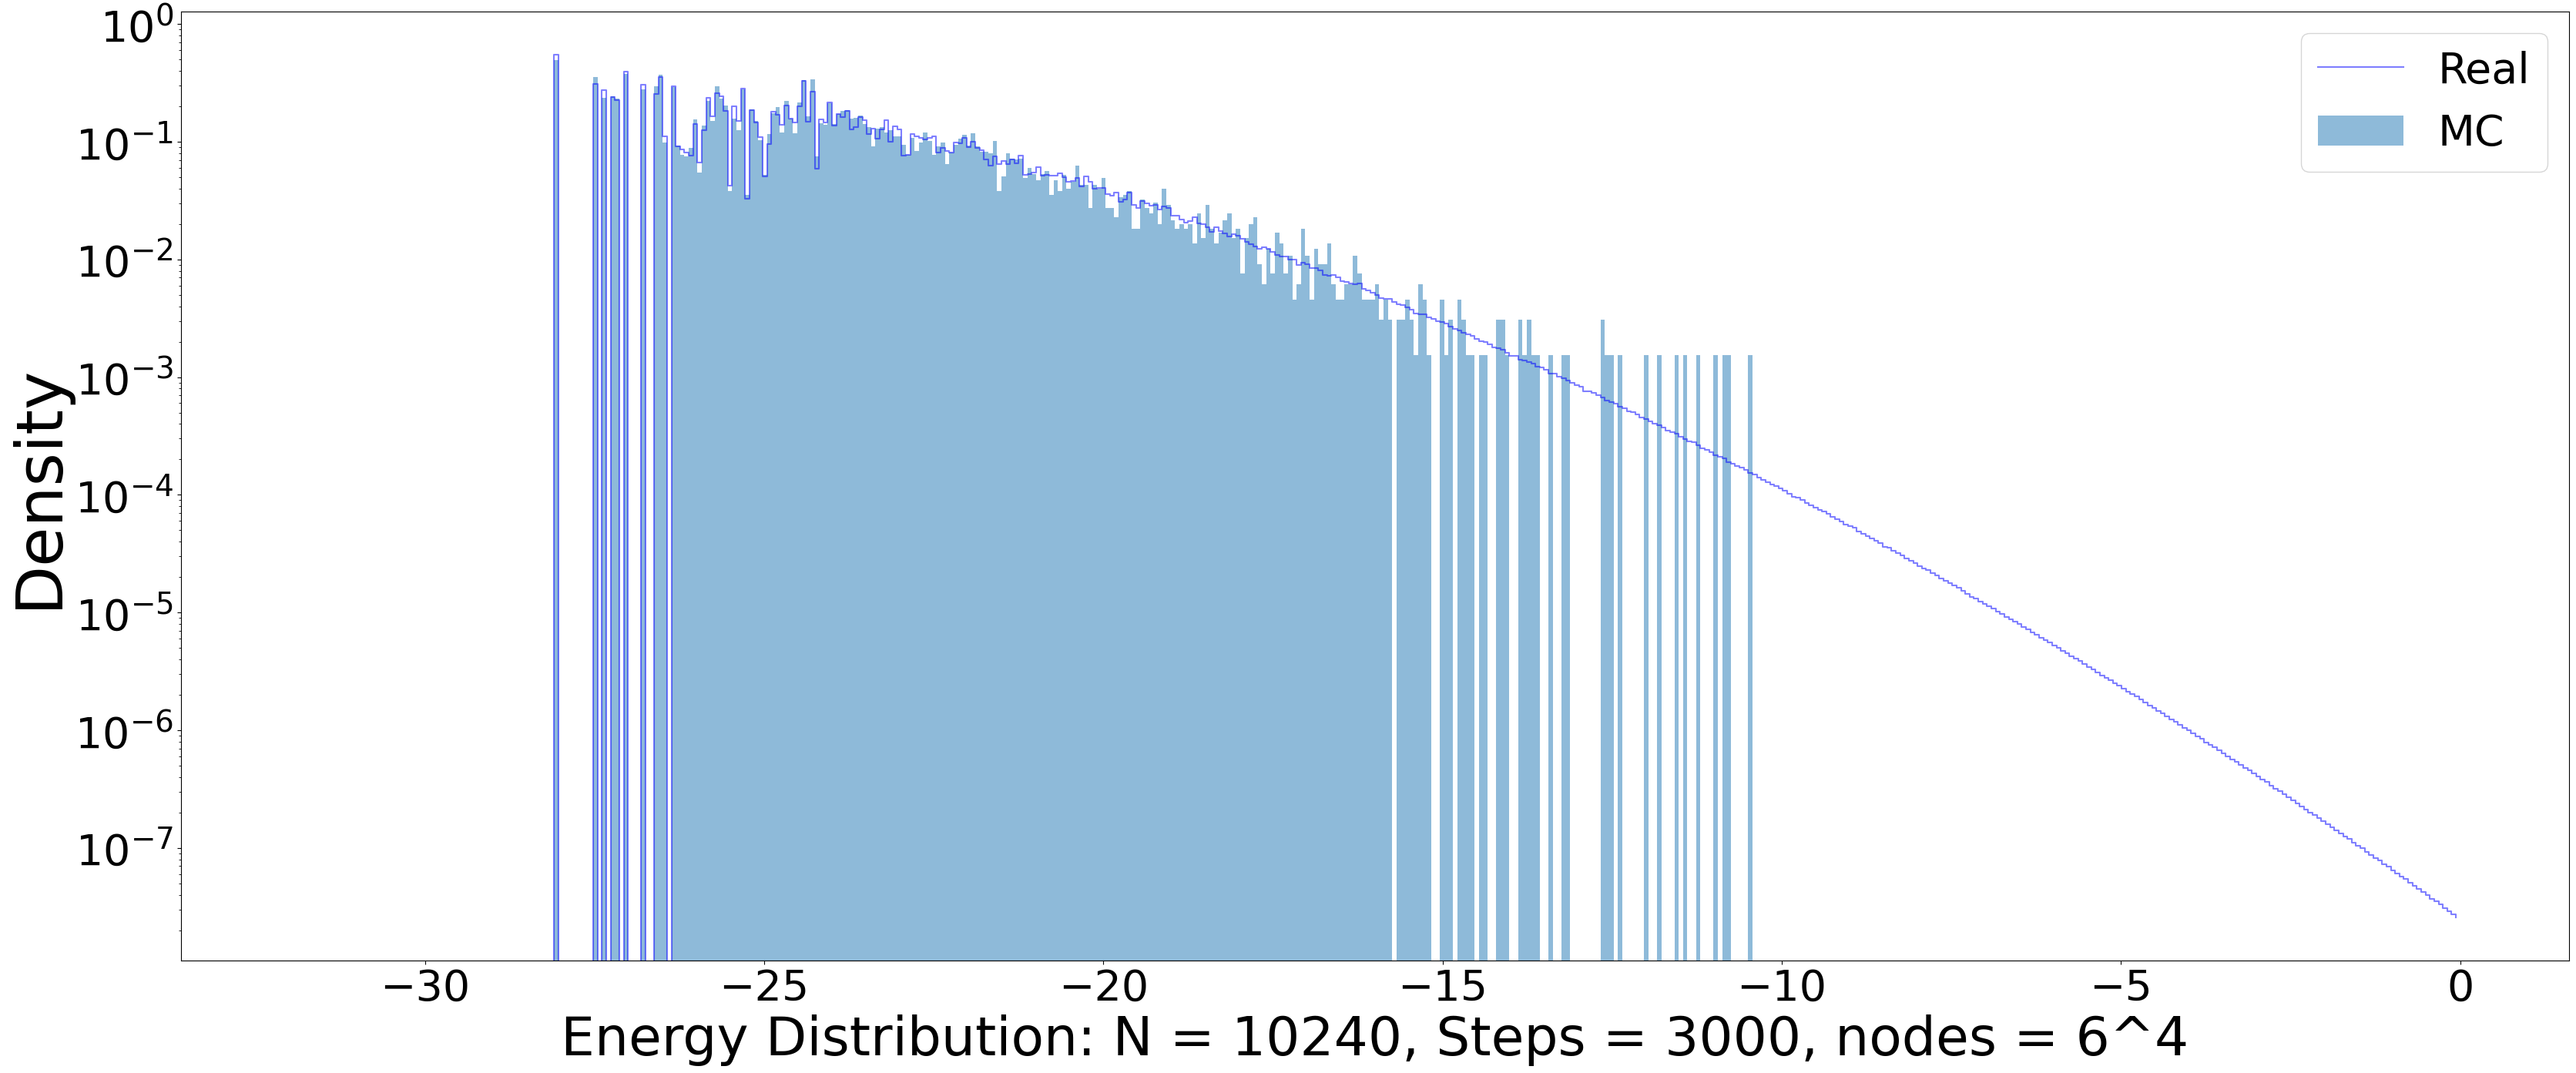

In [32]:
plot_energy_distribution(sampling_energy_6_10240_3000, true_state_energy_6_10240_3000, -32, 0, bins = 500, number_of_steps= 3000, node_per_partition=6)


In [19]:
sampling_energy_6_10240_200, true_state_energy_6_10240_200 = compute_partition_function(prbm_6, 6, number_of_steps = 200, number_of_samples= 10240)

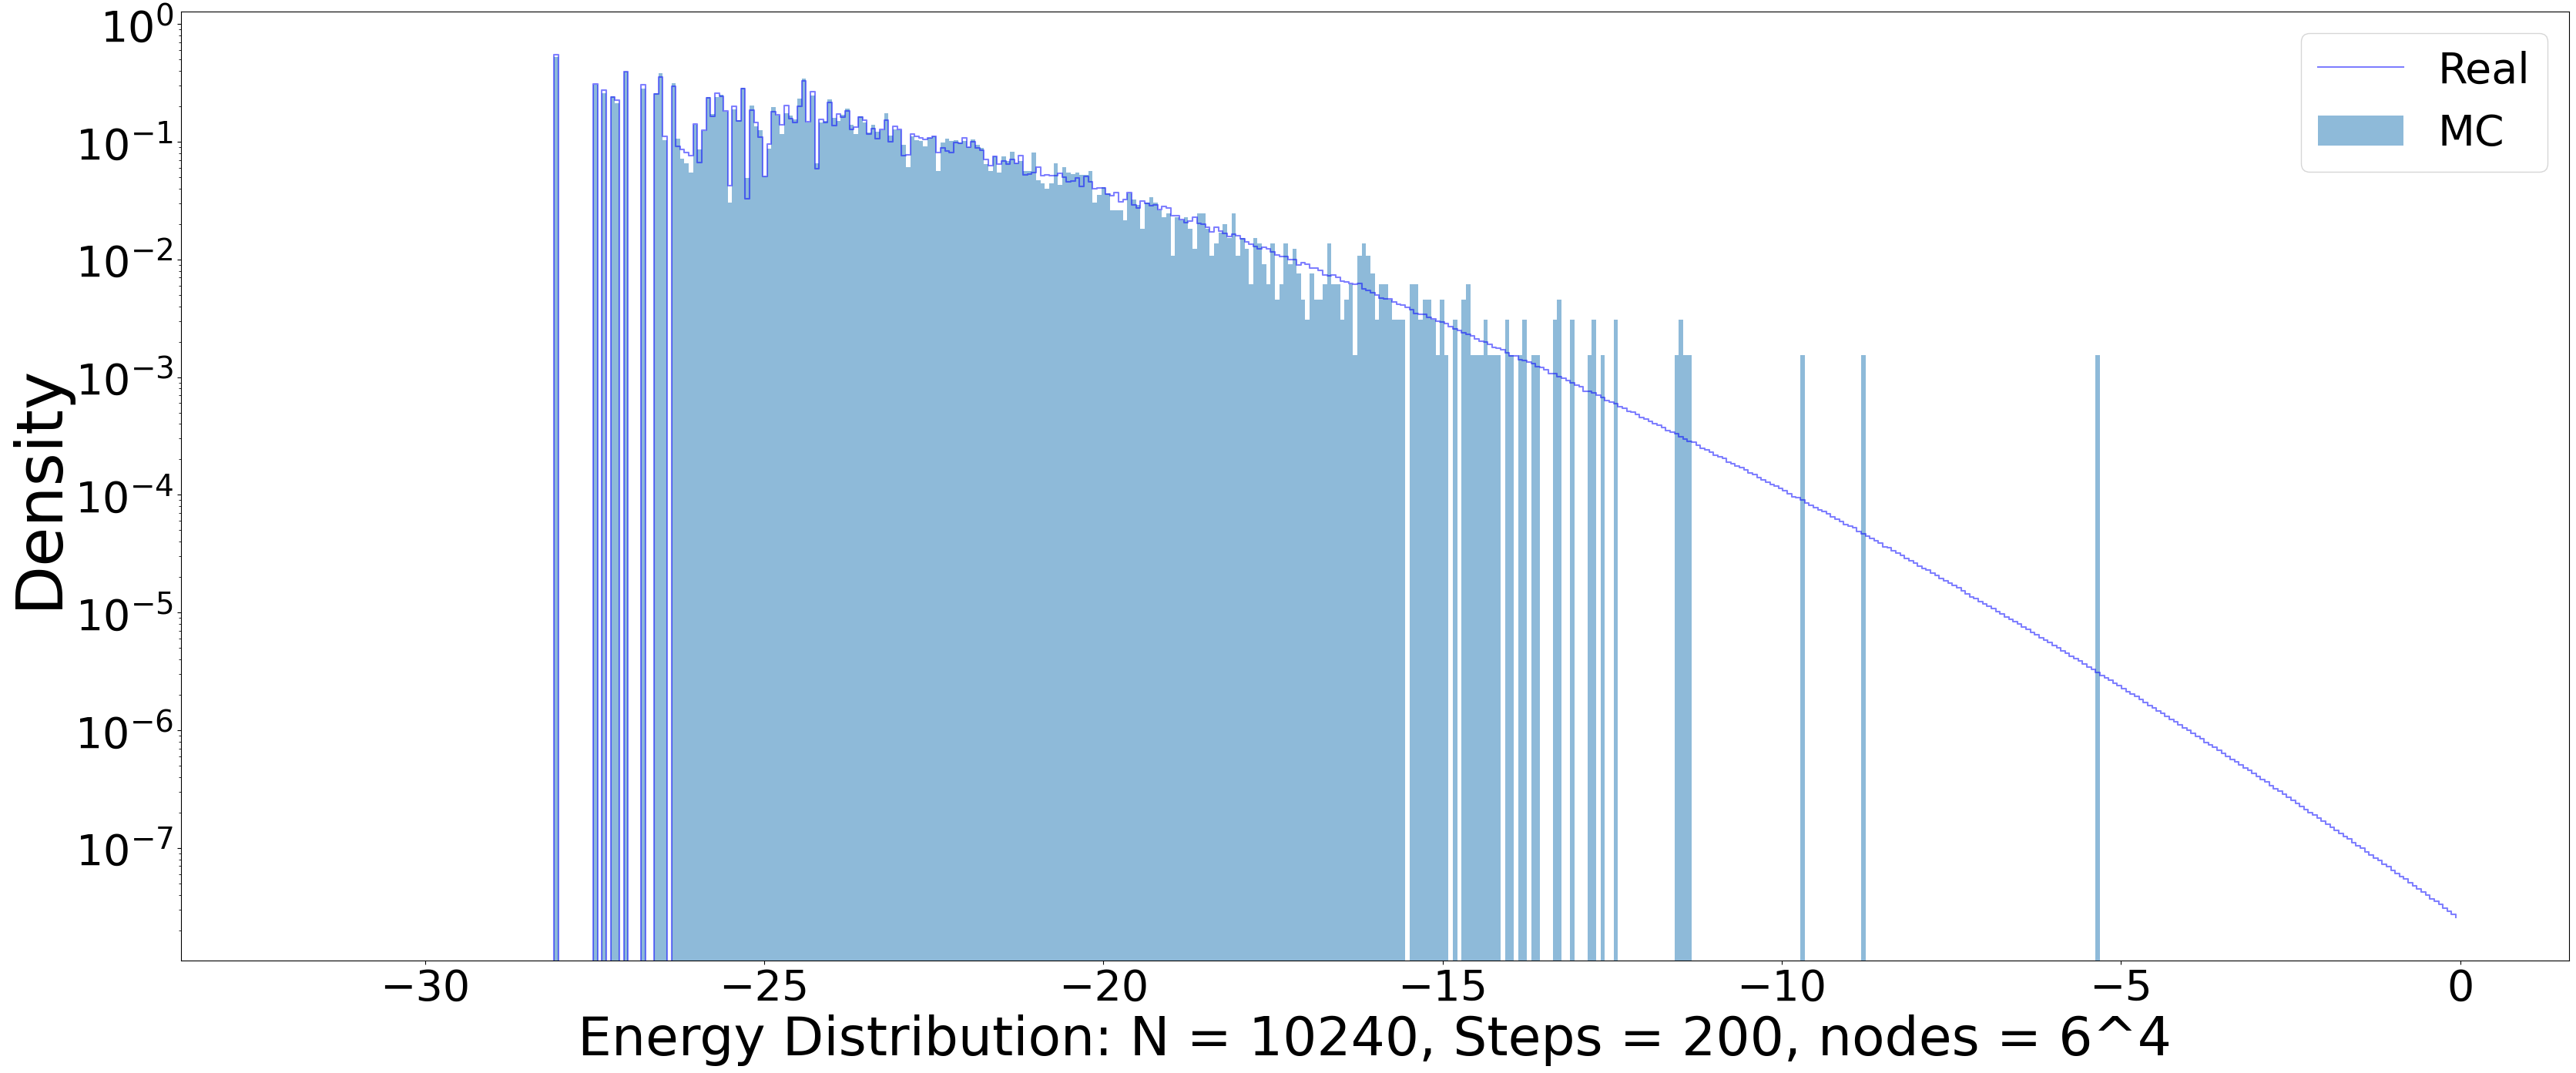

In [33]:
plot_energy_distribution(sampling_energy_6_10240_200, true_state_energy_6_10240_200, -32, 0, bins = 500, number_of_steps= 200, node_per_partition=6)

In [38]:
sampling_energy_3_10240_50, true_state_energy_3_10240_50 = compute_partition_function(prbm_3, 3, number_of_steps = 50, number_of_samples= 10240)

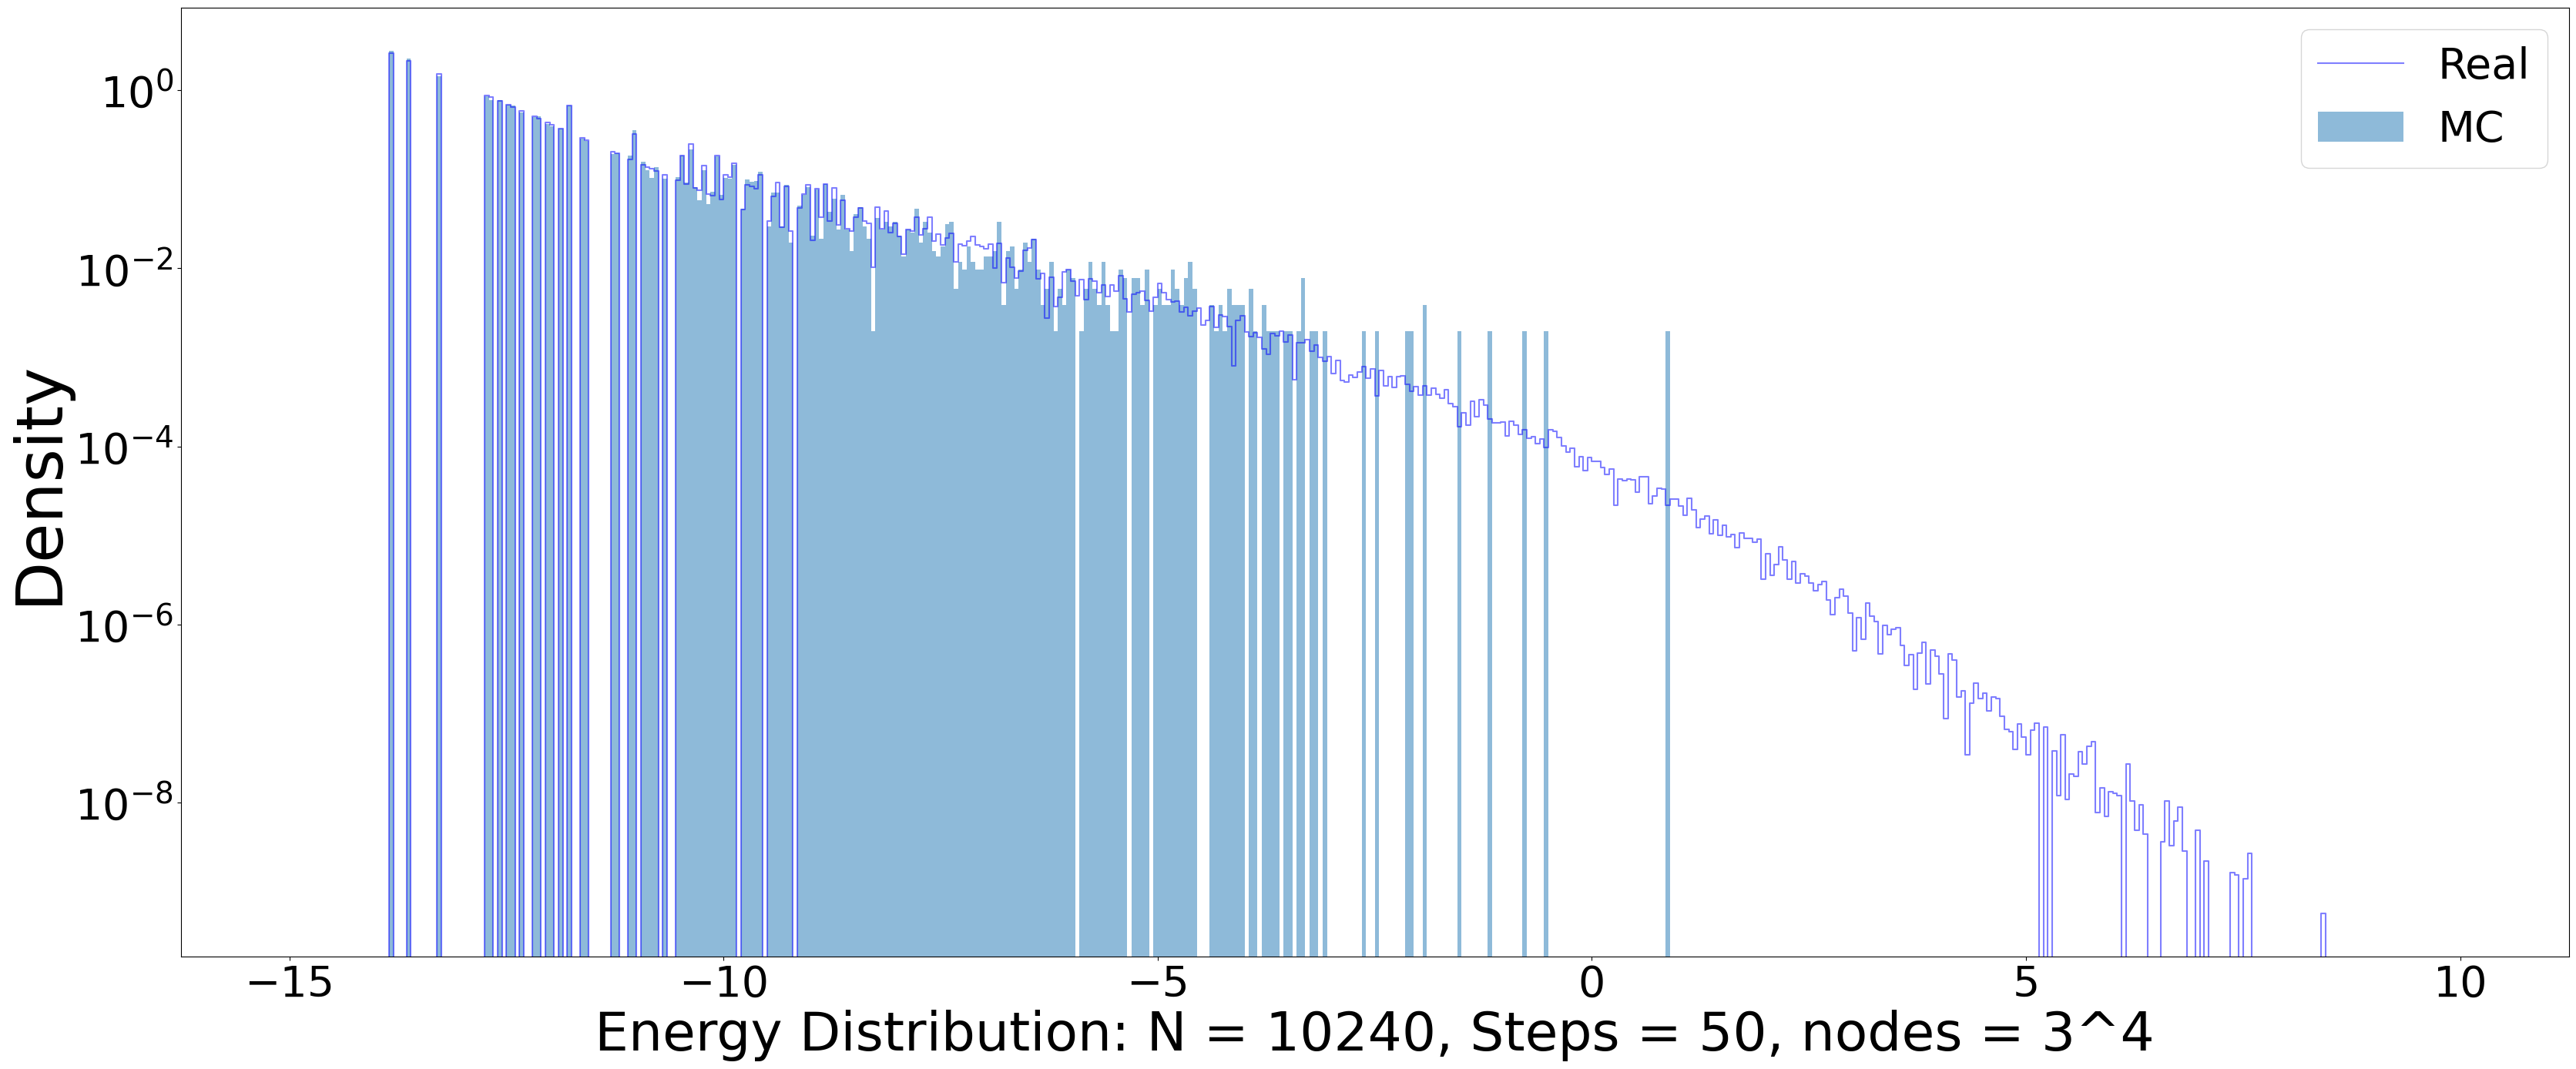

In [40]:
plot_energy_distribution(sampling_energy_3_10240_50, true_state_energy_3_10240_50, -15, 10, bins = 500, number_of_steps= 50, node_per_partition=3)

In [41]:
sampling_energy_3_10240_3000, true_state_energy_3_10240_3000 = compute_partition_function(prbm_3, 3, number_of_steps = 3000, number_of_samples= 10240)

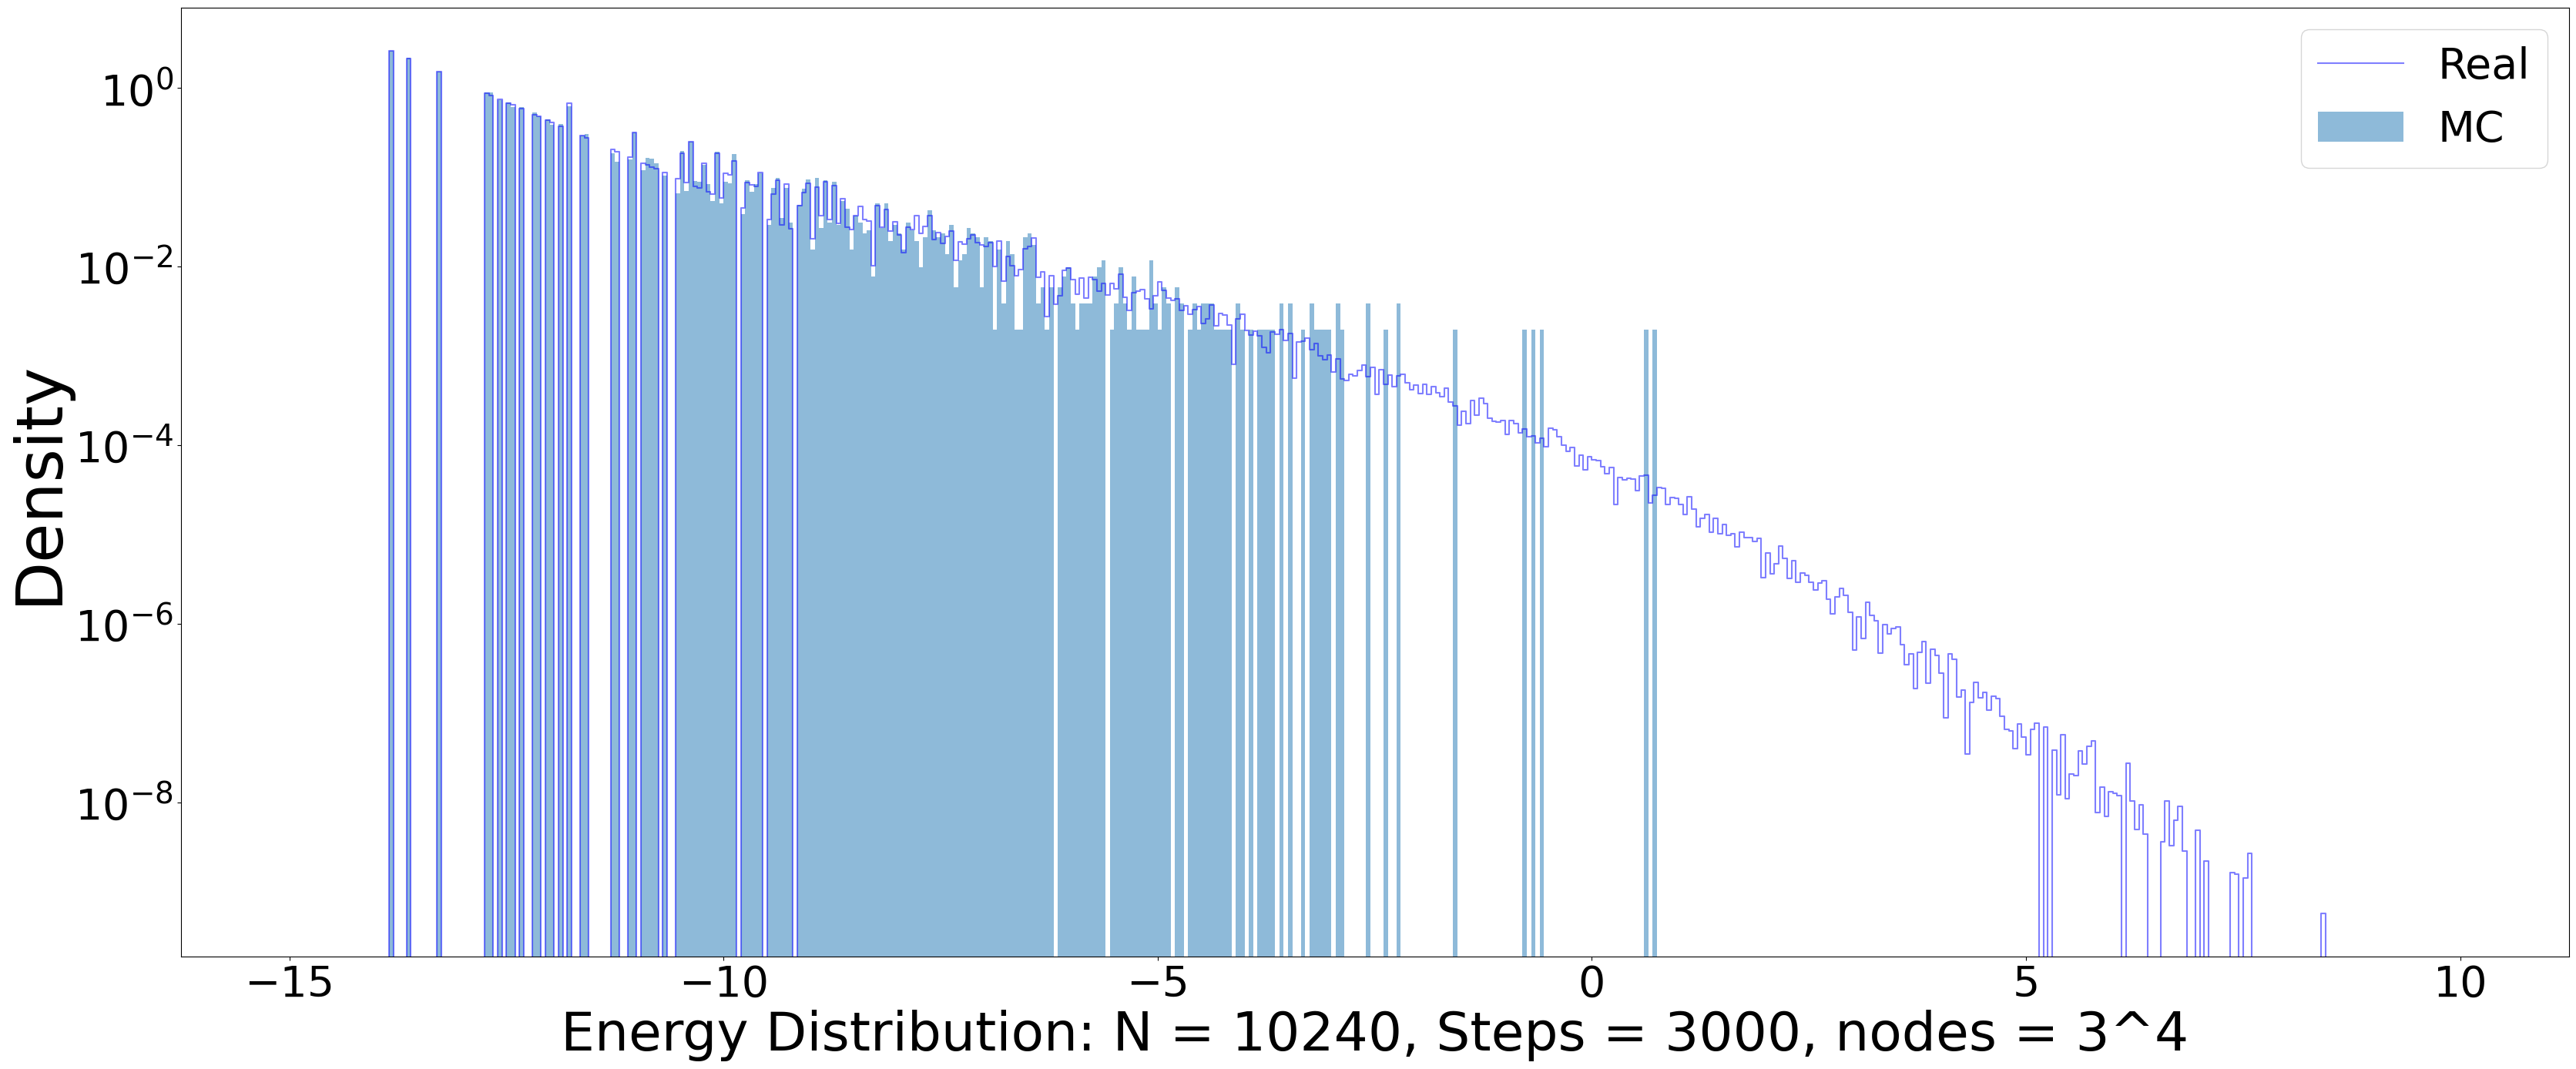

In [42]:
plot_energy_distribution(sampling_energy_3_10240_3000, true_state_energy_3_10240_3000, -15, 10, bins = 500, number_of_steps= 3000, node_per_partition=3)

In [ ]:
sampling_energy_3_1024, true_state_energy_3_1024 = compute_partition_function(prbm_3, 3, number_of_steps = 3000, number_of_samples= 1024)


In [ ]:
plot_energy_distribution(sampling_energy_3_1024, true_state_energy_3_1024, -12, 12, bins = 100)

In [ ]:
sampling_energy_3_10240, true_state_energy_3_10240 = compute_partition_function(prbm_3, 3, number_of_steps = 3000, number_of_samples= 10240)

In [ ]:
plot_energy_distribution(sampling_energy_3_10240, true_state_energy_3_10240, -12, 12, bins = 100)

In [ ]:
sampling_energy_6_3, true_state_energy_6_3 = compute_partition_function(prbm_3, 3, number_of_steps = 3000, number_of_samples= 102400)

In [ ]:
plot_energy_distribution(sampling_energy_6_3, true_state_energy_6_3, -12, 12, bins = 100)

In [ ]:
plot_energy_distribution(sampling_energy_6_3, true_state_energy_6_3, -10, 10, bins = 100, yscale='linear')

In [ ]:
sampling_energy_6_10240, true_state_energy_6_10240 = compute_partition_function(prbm_6, 6, number_of_steps = 3000, number_of_samples= 10240)

In [ ]:
plot_energy_distribution(sampling_energy_6_10240, true_state_energy_6_10240, -25, 35, bins = 100, node_per_partition = 6)

In [ ]:
def scale_weights(prbm, factor):
    for param in prbm._weight_dict.values():
        param.data *= factor

In [ ]:
scale_weights(prbm_3, 5)

In [ ]:
sampling_energy_3_10240_5, true_state_energy_3_10240_5 = compute_partition_function(prbm_3, 3, number_of_steps = 3000, number_of_samples= 102400)

In [ ]:
plot_energy_distribution(sampling_energy_3_10240_5, true_state_energy_3_10240_5, -45, -20, bins = 100)

In [ ]:
plot_energy_distribution(sampling_energy_3_10240_5, true_state_energy_3_10240_5, -45, -20, bins = 100, yscale='linear')